# Setup Notebook

In [1]:
# Set Working Directory
import os
os.chdir('..')

# Set max rows to display when DataFrames are printed
import pandas as pd
pd.options.display.max_rows = 300

# Background

The US Primary and Secondary School System (public and charter elementary, middle, and high schools) is very large. However, the scale of the education system is often lost in our discussions. Figure 1 below illustrates the size of the US Primary and Secondary School System by comparing it with [US Defense](https://en.wikipedia.org/wiki/Military_budget_of_the_United_States).

![Figure 1: Overall government spending on defense and education (primary/secondary) are comparable.](images/spendingdefenseeducation.jpg)

US primary and secondary education's total funding is comparable to the US military budget, which is by far, the largest in the world. However, unlike the military, which is federally funded, education is mostly funded by local and state governments.

Because of education's scale, seemingly minor phenomena can have a major impact. As shown in Figure 2 below, the vast majority of 2010 school districts were still operational in 2015. However, the mere 4 percent of school districts that closed accounted for over $4 billions in government spending, and more importantly, about 380,000 students faced disruptions which could [harm communities](https://www.nytimes.com/2018/06/13/us/arena-wisconsin-schools-empty.html).

![Figure 2: More than 95 percent of school districts in 2010 remained operational in 2015.](images/2010pie.png)

By examining these "at-risk" school districts, education agencies and non-profit organizations can determine actions which may mitigate the effects of disruptions. To conduct studies on at-risk school districts, researchers must first identify them. Machine learning can be used to predict the likelihood of school districts closing within five years, and I created a binary classification model.

To complete the task, I completed the following steps.
1. Load the Data: Find and acquire data for analysis.
2. Wrangle the Data: Convert the data into a format suitable for further analysis.
3. Explore the Data: Identify patterns, develop an understanding of underlying distributions, and select variables most relevant for completing the task.
4. Build and Select Machine Learning Model: Establish evaluation metric, build multiple models, and select the best performing model based on the metric.
5. Provide Recommendations: Provide guidelines for using insights generated by the model, and provide recommendations for further work.

# Loading the Data
To complete this supervised learning task, I used the National Center of Education Statistic's [Common Core of Data](https://nces.ed.gov/ccd/). The Common Core of Data contains all information on primary and secondary school districts used by the Department of Education. It covers years between 1990 and 2015, and it contains hundreds of variables such as student demographics, revenue sources, and spending categories.

The data is stored in separate tab-delimited files on CCD's website. I downloaded the files from the website, and then stored the files within zipped archives. Table 1 below lists the files I used for this project.

![Table 1: The data was stored as separate tab-delimited text files on CCD's website.](images/files.png)

For this project, I completed data wrangling tasks with Python and Pandas. Before proceeding, I loaded the files into [Pandas DataFrames](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python).

In [2]:
import zipfile # I used the zipfile library to access compressed archives

# Compressed archives were stored in the "data" folder within the project directory
finance_archive = zipfile.ZipFile('data/finance.zip', 'r')
universe_archive = zipfile.ZipFile('data/universe.zip', 'r')

# Read finance data
finance_2010 = pd.read_csv(
    finance_archive.open('finance_2010.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')
finance_2011 = pd.read_csv(
    finance_archive.open('finance_2011.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')

# Read universe data
universe_2010 = pd.read_csv(
    universe_archive.open('universe_2010.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')
universe_2011 = pd.read_csv(
    universe_archive.open('universe_2011.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')

# Read school universe data
school_universe_2010 = pd.read_csv(
    universe_archive.open('school_universe_2010.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')

# Read directory data
universe_2015_directory = pd.read_csv(
    universe_archive.open('universe_2015_directory.txt'),
    dtype='str',
    delimiter='\t',
    encoding='windows-1252')
universe_2016_directory = pd.read_csv(
    universe_archive.open('universe_2016_directory.txt'),
    dtype='str',
    delimiter=',',
    encoding='windows-1252')

To verify the data was correctly loaded into DataFrames, I printed the shape of each DataFrame I created.

In [3]:
# print shape of each DataFrame
print('finance_2010:            ', finance_2010.shape)
print('finance_2011:            ', finance_2011.shape)
print('universe_2010:           ', universe_2010.shape)
print('universe_2011:           ', universe_2011.shape)
print('school_universe_2010:    ', school_universe_2010.shape)
print('universe_2015_directory: ', universe_2015_directory.shape)
print('universe_2016_directory: ', universe_2016_directory.shape)

finance_2010:             (18247, 256)
finance_2011:             (18297, 256)
universe_2010:            (18439, 58)
universe_2011:            (18478, 319)
school_universe_2010:     (103959, 289)
universe_2015_directory:  (18834, 56)
universe_2016_directory:  (18893, 57)


There are more than 18,000 school districts, and there are hundreds of variables available for each school district.

# Wrangling the Data

Right now, the data is stored in multiple DataFrames. I wrangled the data from each school year into a [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) DataFrame to simplify analysis. Figure 3 below summarizes the process I used to transform the data into tidy data.

![Figure 3: Tidying the data involved aggregating, merging, labeling, and encoding.](images/preprocessing_steps.png)

The preprocessing steps are very similar between the 2010 and 2011 datasets. The main difference is that 2010 demographic information is only available at the school level, and it needs to be aggregated by the school district level.

### Aggregating School Universe Data (2010)

Each record within the school universe files represents a single school. For my tidy dataset, each record will represent a school district, so I aggregated the school universe data by school districts. Figure 3 below illustrates how schools are aggregated by district.

![Figure 3: Numerical columns in 2010 school universe were summed by school district.](images/aggregation_example.png)

In [4]:
# Aggregate school_universe_2010
# Specify types 
df_types = {
    'NCESSCH': 'str', 'FIPST': 'str', 'LEAID': 'str', 'SCHNO': 'str', 'STID': 'str', 'SEASCH': 'str', 
    'LEANM': 'str', 'SCHNAM': 'str', 'PHONE': 'str', 'MSTREE': 'str', 'MCITY': 'str', 'MSTATE': 'str', 
    'MZIP': 'str', 'MZIP4': 'str', 'LSTREE': 'str', 'LCITY': 'str', 'LSTATE': 'str', 'LZIP': 'str', 
    'LZIP4': 'str', 'TYPE': 'str', 'STATUS': 'str', 'ULOCAL': 'str', 'LATCOD': 'str', 'LONCOD': 'str', 
    'CONUM': 'str', 'CONAME': 'str', 'CDCODE': 'str', 'FTE': 'float', 'GSLO': 'str', 'GSHI': 'str', 
    'LEVEL': 'str', 'TITLEI': 'str', 'STITLI': 'str', 'MAGNET': 'str', 'CHARTR': 'str', 'SHARED': 'str', 
    'BIES': 'str', 'FRELCH': 'float', 'REDLCH': 'float', 'TOTFRL': 'float', 'RACECAT': 'str', 'PK': 'float', 
    'AMPKM': 'float', 'AMPKF': 'float', 'ASPKM': 'float', 'ASPKF': 'float', 'HIPKM': 'float', 'HIPKF': 'float', 
    'BLPKM': 'float', 'BLPKF': 'float', 'WHPKM': 'float', 'WHPKF': 'float', 'HPPKM': 'float', 'HPPKF': 'float', 
    'TRPKM': 'float', 'TRPKF': 'float', 'KG': 'float', 'AMKGM': 'float', 'AMKGF': 'float', 'ASKGM': 'float', 
    'ASKGF': 'float', 'HIKGM': 'float', 'HIKGF': 'float', 'BLKGM': 'float', 'BLKGF': 'float', 'WHKGM': 'float', 
    'WHKGF': 'float', 'HPKGM': 'float', 'HPKGF': 'float', 'TRKGM': 'float', 'TRKGF': 'float', 'G01': 'float', 
    'AM01M': 'float', 'AM01F': 'float', 'AS01M': 'float', 'AS01F': 'float', 'HI01M': 'float', 'HI01F': 'float',
    'BL01M': 'float', 'BL01F': 'float', 'WH01M': 'float', 'WH01F': 'float', 'HP01M': 'float', 'HP01F': 'float', 
    'TR01M': 'float', 'TR01F': 'float', 'G02': 'float', 'AM02M': 'float', 'AM02F': 'float', 'AS02M': 'float', 
    'AS02F': 'float', 'HI02M': 'float', 'HI02F': 'float', 'BL02M': 'float', 'BL02F': 'float', 'WH02M': 'float', 
    'WH02F': 'float', 'HP02M': 'float', 'HP02F': 'float', 'TR02M': 'float', 'TR02F': 'float', 'G03': 'float', 
    'AM03M': 'float', 'AM03F': 'float', 'AS03M': 'float', 'AS03F': 'float', 'HI03M': 'float', 'HI03F': 'float', 
    'BL03M': 'float', 'BL03F': 'float', 'WH03M': 'float', 'WH03F': 'float', 'HP03M': 'float', 'HP03F': 'float', 
    'TR03M': 'float', 'TR03F': 'float', 'G04': 'float', 'AM04M': 'float', 'AM04F': 'float', 'AS04M': 'float', 
    'AS04F': 'float', 'HI04M': 'float', 'HI04F': 'float', 'BL04M': 'float', 'BL04F': 'float', 'WH04M': 'float', 
    'WH04F': 'float', 'HP04M': 'float', 'HP04F': 'float', 'TR04M': 'float', 'TR04F': 'float', 'G05': 'float', 
    'AM05M': 'float', 'AM05F': 'float', 'AS05M': 'float', 'AS05F': 'float', 'HI05M': 'float', 'HI05F': 'float', 
    'BL05M': 'float', 'BL05F': 'float', 'WH05M': 'float', 'WH05F': 'float', 'HP05M': 'float', 'HP05F': 'float', 
    'TR05M': 'float', 'TR05F': 'float', 'G06': 'float', 'AM06M': 'float', 'AM06F': 'float', 'AS06M': 'float', 
    'AS06F': 'float', 'HI06M': 'float', 'HI06F': 'float', 'BL06M': 'float', 'BL06F': 'float', 'WH06M': 'float', 
    'WH06F': 'float', 'HP06M': 'float', 'HP06F': 'float', 'TR06M': 'float', 'TR06F': 'float', 'G07': 'float', 
    'AM07M': 'float', 'AM07F': 'float',  'AS07M': 'float', 'AS07F': 'float', 'HI07M': 'float', 'HI07F': 'float',  
    'BL07M': 'float', 'BL07F': 'float', 'WH07M': 'float', 'WH07F': 'float', 'HP07M': 'float', 'HP07F': 'float', 
    'TR07M': 'float', 'TR07F': 'float', 'G08': 'float', 'AM08M': 'float', 'AM08F': 'float', 'AS08M': 'float', 
    'AS08F': 'float', 'HI08M': 'float', 'HI08F': 'float', 'BL08M': 'float', 'BL08F': 'float', 'WH08M': 'float', 
    'WH08F': 'float', 'HP08M': 'float', 'HP08F': 'float', 'TR08M': 'float', 'TR08F': 'float', 'G09': 'float', 
    'AM09M': 'float', 'AM09F': 'float', 'AS09M': 'float', 'AS09F': 'float', 'HI09M': 'float', 'HI09F': 'float', 
    'BL09M': 'float', 'BL09F': 'float', 'WH09M': 'float', 'WH09F': 'float', 'HP09M': 'float', 'HP09F': 'float', 
    'TR09M': 'float', 'TR09F': 'float', 'G10': 'float', 'AM10M': 'float', 'AM10F': 'float', 'AS10M': 'float', 
    'AS10F': 'float', 'HI10M': 'float', 'HI10F': 'float', 'BL10M': 'float', 'BL10F': 'float', 'WH10M': 'float', 
    'WH10F': 'float', 'HP10M': 'float', 'HP10F': 'float', 'TR10M': 'float', 'TR10F': 'float', 'G11': 'float', 
    'AM11M': 'float', 'AM11F': 'float', 'AS11M': 'float', 'AS11F': 'float', 'HI11M': 'float', 'HI11F': 'float', 
    'BL11M': 'float', 'BL11F': 'float', 'WH11M': 'float', 'WH11F': 'float', 'HP11M': 'float', 'HP11F': 'float', 
    'TR11M': 'float', 'TR11F': 'float', 'G12': 'float', 'AM12M': 'float', 'AM12F': 'float', 'AS12M': 'float', 
    'AS12F': 'float', 'HI12M': 'float', 'HI12F': 'float', 'BL12M': 'float', 'BL12F': 'float', 'WH12M': 'float', 
    'WH12F': 'float', 'HP12M': 'float', 'HP12F': 'float', 'TR12M': 'float', 'TR12F': 'float', 'UG': 'float', 
    'AMUGM': 'float', 'AMUGF': 'float', 'ASUGM': 'float', 'ASUGF': 'float', 'HIUGM': 'float', 'HIUGF': 'float', 
    'BLUGM': 'float', 'BLUGF': 'float', 'WHUGM': 'float', 'WHUGF': 'float', 'HPUGM': 'float', 'HPUGF': 'float', 
    'TRUGM': 'float', 'TRUGF': 'float', 'MEMBER': 'float', 'AM': 'float', 'AMALM': 'float', 'AMALF': 'float', 
    'ASIAN': 'float', 'ASALM': 'float', 'ASALF': 'float', 'HISP': 'float', 'HIALM': 'float', 'HIALF': 'float', 
    'BLACK': 'float', 'BLALM': 'float', 'BLALF': 'float', 'WHITE': 'float', 'WHALM': 'float', 'WHALF': 'float', 
    'PACIFIC': 'float', 'HPALM': 'float', 'HPALF': 'float', 'TR': 'float', 'TRALM': 'float', 'TRALF': 'float', 
    'TOTETH': 'float'
}

# Convert float columns to float
float_columns = []
school_universe_2010.columns = df_types.keys()
for column, dtype in df_types.items():
    if dtype == 'float':
        float_columns.append(column)
        school_universe_2010[column] = school_universe_2010[column].astype(float)
        
# Aggregate (sum) float columns by school district('LEAID')
float_columns.append('LEAID')
school_universe_2010 = school_universe_2010[float_columns].groupby('LEAID').sum(skipna=True, min_count=1).reset_index()

To verify the school universe data was correctly aggregated, I printed the shape of the updated DataFrames. Since each record should now represent a school district, there should be around 18,000 records in each DataFrame.

In [5]:
print('school_universe_2010:', school_universe_2010.shape)

school_universe_2010: (17177, 253)


There are fewer school districts in the school universe data than the universe data. Upon further inspection, I discovered this is because many school districts do not have any schools.

In [6]:
print('Districts with no schools 2010:', len(universe_2010[universe_2010['SCH09'] == '0']))

Districts with no schools 2010: 1456


### Merging the Data

![Figure 4: An outer join was used to join DataFrames](images/merge.png)

Before merging the DataFrames, I first standardized the column names (i.e. "GSLO09" and "GSLO10" should both be "GSLO"). I also converted columns into the proper types to ensure proper aggregation.

In [7]:
# Commonize columns

# universe_2010
# Specify types 
df_types = {
    'LEAID': 'str', 'FIPST': 'str', 'STID': 'str', 'NAME': 'str', 'PHONE': 'str', 'MSTREE': 'str', 'MCITY': 'str',
    'MSTATE': 'str', 'MZIP': 'str', 'MZIP4': 'str', 'LSTREE': 'str', 'LCITY': 'str', 'LSTATE': 'str', 'LZIP': 'str',
    'LZIP4': 'str', 'TYPE': 'str', 'UNION': 'str', 'CONUM': 'str', 'CONAME': 'str', 'CSA': 'str', 'CBSA': 'str',
    'METMIC': 'str', 'ULOCAL': 'str', 'CDCODE': 'str', 'LATCOD': 'float', 'LONCOD': 'float', 'BOUND': 'str',
    'BIEA': 'str', 'GSLO': 'str', 'GSHI': 'str', 'AGCHRT': 'str', 'SCH': 'float', 'UG': 'float', 'PK12': 'float',
    'MEMBER': 'float', 'SPECED': 'float', 'ELL': 'float', 'PKTCH': 'float', 'KGTCH': 'float', 'ELMTCH': 'float',
    'SECTCH': 'float', 'UGTCH': 'float', 'TOTTCH': 'float', 'AIDES': 'float', 'CORSUP': 'float', 'ELMGUI': 'float',
    'SECGUI': 'float', 'OTHGUI': 'float', 'TOTGUI': 'float', 'LIBSPE': 'float', 'LIBSUP': 'float', 'LEAADM': 'float',
    'LEASUP': 'float', 'SCHADM': 'float', 'SCHSUP': 'float', 'STUSUP': 'float', 'OTHSUP': 'float', 'RACECAT': 'float'
}
universe_2010.columns = df_types.keys()

# Convert float columns to float
for column, dtype in df_types.items():
    if dtype == 'float':
        universe_2010[column] = universe_2010[column].astype(float)
        
# universe_2011
# Specify types
df_types = {
    'SURVYEAR': 'str', 'LEAID': 'str', 'FIPST': 'str', 'STID': 'str', 'NAME': 'str', 'PHONE': 'str', 'MSTREE': 'str',
    'MCITY': 'str', 'MSTATE': 'str', 'MZIP': 'str', 'MZIP4': 'str', 'LSTREE': 'str', 'LCITY': 'str', 'LSTATE': 'str',
    'LZIP': 'str', 'LZIP4': 'str', 'TYPE': 'str', 'UNION': 'str', 'CONUM': 'str', 'CONAME': 'str', 'CSA': 'str',
    'CBSA': 'str', 'METMIC': 'str', 'ULOCAL': 'str', 'CDCODE': 'str', 'LATCOD': 'float', 'LONCOD': 'float',
    'BIEA': 'str', 'BOUND': 'str', 'GSLO': 'str', 'GSHI': 'str', 'PKOFFRD': 'str', 'KGOFFRD': 'str', 'G01OFFRD': 'str',
    'G02OFFRD': 'str', 'G03OFFRD': 'str', 'G04OFFRD': 'str', 'G05OFFRD': 'str', 'G06OFFRD': 'str', 'G07OFFRD': 'str',
    'G08OFFRD': 'str', 'G09OFFRD': 'str', 'G10OFFRD': 'str', 'G11OFFRD': 'str', 'G12OFFRD': 'str', 'UGOFFRD': 'str',
    'AGCHRT': 'str', 'SCH': 'float', 'SPECED': 'float', 'ELL': 'float', 'PKTCH': 'float', 'KGTCH': 'float',
    'ELMTCH': 'float', 'SECTCH': 'float', 'UGTCH': 'float', 'TOTTCH': 'float', 'AIDES': 'float', 'CORSUP': 'float',
    'ELMGUI': 'float', 'SECGUI': 'float', 'OTHGUI': 'float', 'TOTGUI': 'float', 'LIBSPE': 'float', 'LIBSUP': 'float',
    'LEAADM': 'float', 'LEASUP': 'float', 'SCHADM': 'float', 'SCHSUP': 'float', 'STUSUP': 'float', 'OTHSUP': 'float',
    'RACECAT': 'float', 'PK': 'float', 'AMPKM': 'float', 'AMPKF': 'float', 'ASPKM': 'float', 'ASPKF': 'float',
    'HIPKM': 'float', 'HIPKF': 'float', 'BLPKM': 'float', 'BLPKF': 'float', 'WHPKM': 'float', 'WHPKF': 'float',
    'HPPKM': 'float', 'HPPKF': 'float', 'TRPKM': 'float', 'TRPKF': 'float', 'KG': 'float', 'AMKGM': 'float',
    'AMKGF': 'float', 'ASKGM': 'float', 'ASKGF': 'float', 'HIKGM': 'float', 'HIKGF': 'float', 'BLKGM': 'float',
    'BLKGF': 'float', 'WHKGM': 'float', 'WHKGF': 'float', 'HPKGM': 'float', 'HPKGF': 'float', 'TRKGM': 'float',
    'TRKGF': 'float', 'G01': 'float', 'AM01M': 'float', 'AM01F': 'float', 'AS01M': 'float', 'AS01F': 'float',
    'HI01M': 'float', 'HI01F': 'float', 'BL01M': 'float', 'BL01F': 'float', 'WH01M': 'float', 'WH01F': 'float',
    'HP01M': 'float', 'HP01F': 'float', 'TR01M': 'float', 'TR01F': 'float', 'G02': 'float', 'AM02M': 'float',
    'AM02F': 'float', 'AS02M': 'float', 'AS02F': 'float', 'HI02M': 'float', 'HI02F': 'float', 'BL02M': 'float',
    'BL02F': 'float', 'WH02M': 'float', 'WH02F': 'float', 'HP02M': 'float', 'HP02F': 'float', 'TR02M': 'float',
    'TR02F': 'float', 'G03': 'float', 'AM03M': 'float', 'AM03F': 'float', 'AS03M': 'float', 'AS03F': 'float',
    'HI03M': 'float', 'HI03F': 'float', 'BL03M': 'float', 'BL03F': 'float', 'WH03M': 'float', 'WH03F': 'float',
    'HP03M': 'float', 'HP03F': 'float', 'TR03M': 'float', 'TR03F': 'float', 'G04': 'float', 'AM04M': 'float',
    'AM04F': 'float', 'AS04M': 'float', 'AS04F': 'float', 'HI04M': 'float', 'HI04F': 'float', 'BL04M': 'float',
    'BL04F': 'float', 'WH04M': 'float', 'WH04F': 'float', 'HP04M': 'float', 'HP04F': 'float', 'TR04M': 'float',
    'TR04F': 'float', 'G05': 'float', 'AM05M': 'float', 'AM05F': 'float', 'AS05M': 'float', 'AS05F': 'float',
    'HI05M': 'float', 'HI05F': 'float', 'BL05M': 'float', 'BL05F': 'float', 'WH05M': 'float', 'WH05F': 'float',
    'HP05M': 'float', 'HP05F': 'float', 'TR05M': 'float', 'TR05F': 'float', 'G06': 'float', 'AM06M': 'float',
    'AM06F': 'float', 'AS06M': 'float', 'AS06F': 'float', 'HI06M': 'float', 'HI06F': 'float', 'BL06M': 'float',
    'BL06F': 'float', 'WH06M': 'float', 'WH06F': 'float', 'HP06M': 'float', 'HP06F': 'float', 'TR06M': 'float',
    'TR06F': 'float', 'G07': 'float', 'AM07M': 'float', 'AM07F': 'float', 'AS07M': 'float', 'AS07F': 'float',
    'HI07M': 'float', 'HI07F': 'float', 'BL07M': 'float', 'BL07F': 'float', 'WH07M': 'float', 'WH07F': 'float',
    'HP07M': 'float', 'HP07F': 'float', 'TR07M': 'float', 'TR07F': 'float', 'G08': 'float', 'AM08M': 'float',
    'AM08F': 'float', 'AS08M': 'float', 'AS08F': 'float', 'HI08M': 'float', 'HI08F': 'float', 'BL08M': 'float',
    'BL08F': 'float', 'WH08M': 'float', 'WH08F': 'float', 'HP08M': 'float', 'HP08F': 'float', 'TR08M': 'float',
    'TR08F': 'float', 'G09': 'float', 'AM09M': 'float', 'AM09F': 'float', 'AS09M': 'float', 'AS09F': 'float',
    'HI09M': 'float', 'HI09F': 'float', 'BL09M': 'float', 'BL09F': 'float', 'WH09M': 'float', 'WH09F': 'float',
    'HP09M': 'float', 'HP09F': 'float', 'TR09M': 'float', 'TR09F': 'float', 'G100': 'float', 'AM10M': 'float',
    'AM10F': 'float', 'AS10M': 'float', 'AS10F': 'float', 'HI10M': 'float', 'HI10F': 'float', 'BL10M': 'float',
    'BL10F': 'float', 'WH10M': 'float', 'WH10F': 'float', 'HP10M': 'float', 'HP10F': 'float', 'TR10M': 'float',
    'TR10F': 'float', 'G11': 'float', 'AM11M': 'float', 'AM11F': 'float', 'AS11M': 'float', 'AS11F': 'float',
    'HI11M': 'float', 'HI11F': 'float', 'BL11M': 'float', 'BL11F': 'float', 'WH11M': 'float', 'WH11F': 'float',
    'HP11M': 'float', 'HP11F': 'float', 'TR11M': 'float', 'TR11F': 'float', 'G12': 'float', 'AM12M': 'float',
    'AM12F': 'float', 'AS12M': 'float', 'AS12F': 'float', 'HI12M': 'float', 'HI12F': 'float', 'BL12M': 'float',
    'BL12F': 'float', 'WH12M': 'float', 'WH12F': 'float', 'HP12M': 'float', 'HP12F': 'float', 'TR12M': 'float',
    'TR12F': 'float', 'UG': 'float', 'AMUGM': 'float', 'AMUGF': 'float', 'ASUGM': 'float', 'ASUGF': 'float',
    'HIUGM': 'float', 'HIUGF': 'float', 'BLUGM': 'float', 'BLUGF': 'float', 'WHUGM': 'float', 'WHUGF': 'float',
    'HPUGM': 'float', 'HPUGF': 'float', 'TRUGM': 'float', 'TRUGF': 'float', 'MEMBER': 'float', 'AM': 'float',
    'AMALM': 'float', 'AMALF': 'float', 'ASIAN': 'float', 'ASALM': 'float', 'ASALF': 'float', 'HISP': 'float',
    'HIALM': 'float', 'HIALF': 'float', 'BLACK': 'float', 'BLALM': 'float', 'BLALF': 'float', 'WHITE': 'float',
    'WHALM': 'float', 'WHALF': 'float', 'PACIFIC': 'float', 'HPALM': 'float', 'HPALF': 'float', 'TR': 'float',
    'TRALM': 'float', 'TRALF': 'float', 'TOTETH': 'float'
}
universe_2011.columns = df_types.keys()

# Convert float columns to float
for column, dtype in df_types.items():
    if dtype == 'float':
        universe_2011[column] = universe_2011[column].astype(float)
        
# finance_2010 and finance_2011
# Specify types
df_types = {
    'LEAID': 'str', 'CENSUSID': 'str', 'FIPST': 'str', 'CONUM': 'str', 'CSA': 'str', 'CBSA': 'str', 'NAME': 'str',
    'STNAME': 'str', 'STABBR': 'str', 'SCHLEV': 'str', 'AGCHRT': 'str', 'YEAR': 'str', 'CCDNF': 'str',
    'CENFILE': 'str', 'GSLO': 'str', 'GSHI': 'str', 'V33': 'float', 'MEMBERSCH': 'float', 'TOTALREV': 'float',
    'TFEDREV': 'float', 'C14': 'float', 'C15': 'float', 'C16': 'float', 'C17': 'float', 'C19': 'float',
    'B11': 'float', 'C20': 'float', 'C25': 'float', 'C36': 'float', 'B10': 'float', 'B12': 'float', 'B13': 'float',
    'TSTREV': 'float', 'C01': 'float', 'C04': 'float', 'C05': 'float', 'C06': 'float', 'C07': 'float', 'C08': 'float',
    'C09': 'float', 'C10': 'float', 'C11': 'float', 'C12': 'float', 'C13': 'float', 'C35': 'float', 'C38': 'float',
    'C39': 'float', 'TLOCREV': 'float', 'T02': 'float', 'T06': 'float', 'T09': 'float', 'T15': 'float',
    'T40': 'float', 'T99': 'float', 'D11': 'float', 'D23': 'float', 'A07': 'float', 'A08': 'float', 'A09': 'float',
    'A11': 'float', 'A13': 'float', 'A15': 'float', 'A20': 'float', 'A40': 'float', 'U11': 'float', 'U22': 'float',
    'U30': 'float', 'U50': 'float', 'U97': 'float', 'C24': 'float', 'TOTALEXP': 'float', 'TCURELSC': 'float',
    'TCURINST': 'float', 'E13': 'float', 'V91': 'float', 'V92': 'float', 'TCURSSVC': 'float', 'E17': 'float',
    'E07': 'float', 'E08': 'float', 'E09': 'float', 'V40': 'float', 'V45': 'float', 'V90': 'float', 'V85': 'float',
    'TCUROTH': 'float', 'E11': 'float', 'V60': 'float', 'V65': 'float', 'TNONELSE': 'float', 'V70': 'float',
    'V75': 'float', 'V80': 'float', 'TCAPOUT': 'float', 'F12': 'float', 'G15': 'float', 'K09': 'float',
    'K10': 'float', 'K11': 'float', 'L12': 'float', 'M12': 'float', 'Q11': 'float', 'I86': 'float', 'Z32': 'float',
    'Z33': 'float', 'Z35': 'float', 'Z36': 'float', 'Z37': 'float', 'Z38': 'float', 'V11': 'float', 'V13': 'float',
    'V15': 'float', 'V17': 'float', 'V21': 'float', 'V23': 'float', 'V37': 'float', 'V29': 'float', 'Z34': 'float',
    'V10': 'float', 'V12': 'float', 'V14': 'float', 'V16': 'float', 'V18': 'float', 'V22': 'float', 'V24': 'float',
    'V38': 'float', 'V30': 'float', 'V32': 'float', 'V93': 'float', '_19H': 'float', '_21F': 'float', '_31F': 'float',
    '_41F': 'float', '_61V': 'float', '_66V': 'float', 'W01': 'float', 'W31': 'float', 'W61': 'float', 'HR1': 'float',
    'HE1': 'float', 'HE2': 'float', 'WEIGHT': 'float', 'FL_V33': 'str', 'FL_MEMBERSC': 'str', 'FL_C14': 'str',
    'FL_C15': 'str', 'FL_C16': 'str', 'FL_C17': 'str', 'FL_C19': 'str', 'FL_B11': 'str', 'FL_C20': 'str',
    'FL_C25': 'str', 'FL_C36': 'str', 'FL_B10': 'str', 'FL_B12': 'str', 'FL_B13': 'str', 'FL_C01': 'str',
    'FL_C04': 'str', 'FL_C05': 'str', 'FL_C06': 'str', 'FL_C07': 'str', 'FL_C08': 'str', 'FL_C09': 'str',
    'FL_C10': 'str', 'FL_C11': 'str', 'FL_C12': 'str', 'FL_C13': 'str', 'FL_C35': 'str', 'FL_C38': 'str',
    'FL_C39': 'str', 'FL_T02': 'str', 'FL_T06': 'str', 'FL_T09': 'str', 'FL_T15': 'str', 'FL_T40': 'str',
    'FL_T99': 'str', 'FL_D11': 'str', 'FL_D23': 'str', 'FL_A07': 'str', 'FL_A08': 'str', 'FL_A09': 'str',
    'FL_A11': 'str', 'FL_A13': 'str', 'FL_A15': 'str', 'FL_A20': 'str', 'FL_A40': 'str', 'FL_U11': 'str',
    'FL_U22': 'str', 'FL_U30': 'str', 'FL_U50': 'str', 'FL_U97': 'str', 'FL_C24': 'str', 'FL_E13': 'str',
    'FL_V91': 'str', 'FL_V92': 'str', 'FL_E17': 'str', 'FL_E07': 'str', 'FL_E08': 'str', 'FL_E09': 'str',
    'FL_V40': 'str', 'FL_V45': 'str', 'FL_V90': 'str', 'FL_V85': 'str', 'FL_E11': 'str', 'FL_V60': 'str',
    'FL_V65': 'str', 'FL_V70': 'str', 'FL_V75': 'str', 'FL_V80': 'str', 'FL_F12': 'str', 'FL_G15': 'str',
    'FL_K09': 'str', 'FL_K10': 'str', 'FL_K11': 'str', 'FL_L12': 'str', 'FL_M12': 'str', 'FL_Q11': 'str',
    'FL_I86': 'str', 'FL_Z32': 'str', 'FL_Z33': 'str', 'FL_Z35': 'str', 'FL_Z36': 'str', 'FL_Z37': 'str',
    'FL_Z38': 'str', 'FL_V11': 'str', 'FL_V13': 'str', 'FL_V15': 'str', 'FL_V17': 'str', 'FL_V21': 'str',
    'FL_V23': 'str', 'FL_V37': 'str', 'FL_V29': 'str', 'FL_Z34': 'str', 'FL_V10': 'str', 'FL_V12': 'str',
    'FL_V14': 'str', 'FL_V16': 'str', 'FL_V18': 'str', 'FL_V22': 'str', 'FL_V24': 'str', 'FL_V38': 'str',
    'FL_V30': 'str', 'FL_V32': 'str', 'FL_V93': 'str', 'FL_19H': 'str', 'FL_21F': 'str', 'FL_31F': 'str',
    'FL_41F': 'str', 'FL_61V': 'str', 'FL_66V': 'str', 'FL_W01': 'str', 'FL_W31': 'str', 'FL_W61': 'str',
    'FL_HR1': 'str', 'FL_HE1': 'str', 'FL_HE2': 'str'
}
finance_2010.columns = df_types.keys()
finance_2011.columns = df_types.keys()

# Convert float columns to float
for column, dtype in df_types.items():
    if dtype == 'float':
        finance_2011[column] = finance_2011[column].astype(float)

The financial, universe, and aggregated school universe data will now be combined into a single DataFrame (for each year). I used the "LEAID" column (unique identification number for each school district) as a key for the merge.

In [8]:
# Merge 2010 data
# Merge finance_2010 and universe_2010
merged_data_2010 = pd.merge(
    finance_2010,
    universe_2010,
    how='outer',
    on=['LEAID', 'FIPST', 'CONUM', 'CSA', 'CBSA', 'NAME', 'AGCHRT', 'GSLO', 'GSHI']
)

# Merge school_universe_2010
merged_data_2010 = pd.merge(
    merged_data_2010,
    school_universe_2010.drop(columns=['MEMBER', 'UG']),
    how='outer',
    on=['LEAID'])

# Merge 2011 data
merged_data_2011 = pd.merge(
    finance_2011,
    universe_2011,
    how='outer',
    on=['LEAID', 'FIPST', 'CONUM', 'CSA', 'CBSA', 'NAME', 'AGCHRT', 'GSLO', 'GSHI']
)

# Verify DataFrames merged correctly
print('merged_data_2010:', merged_data_2010.shape)
print('merged_data_2011:', merged_data_2011.shape)

merged_data_2010: (18473, 555)
merged_data_2011: (18523, 566)


### Labeling the Data

Classification models require [labeled datasets](https://stackoverflow.com/a/19172720). In this case, the labels for each school district represent whether the school district is still operational in five years. To generate labels, I used the universe files from 2015 and 2016. If the school district is listed in the future universe file, and it's status is not "closed," then it is still operational. Otherwise, the school district is no longer operational.

![Figure 5: Data from 2010 and 2011 were labeled using data from 2015 and 2016.](images/labeling.png)

In [9]:
# Create function to label whether school districts remain operational in five years
def calc_five_years_operational(merged_data, directory_data):
    """
    Return pandas dataframe of labeled dataframe

    param dataframe merged_data: dataframe of merged data
    param dataframe directory_data: dataframe with all school districts in 2015
    """
    
    merged_data = merged_data[merged_data['BOUND'] != '2'].copy()
    
    def condition1_generate(x):
        """
        Return boolean of whether school district exists in 5 years

        param string x: LEAID of school district to check
        """
        condition1 = x in directory_data['LEAID'].values
        if condition1:
            condition1 = directory_data.loc[directory_data['LEAID']==x, 'SY_STATUS'].values != '2'
        return condition1

    condition1 = merged_data['LEAID'].apply(condition1_generate)
    condition2 = merged_data['BOUND'].apply(lambda x: x != '2')
    merged_data['exist_five_years'] = condition1 & condition2
    return merged_data

# Apply function to 2010 and 2011 data
labeled_data_2010 = calc_five_years_operational(merged_data_2010, universe_2015_directory)
labeled_data_2011 = calc_five_years_operational(merged_data_2011, universe_2016_directory)

labeled_data_2010['closed_five_years'] = labeled_data_2010['exist_five_years'] == False
labeled_data_2011['closed_five_years'] = labeled_data_2011['exist_five_years'] == False

# Print proportions of school districts that will close within 5 years.
print(
    'Proportion of 2010 school districts at risk:',
    1 - labeled_data_2010['exist_five_years'].sum()/len(labeled_data_2010['exist_five_years'])
)
print(
    'Proportion of 2011 school districts at risk:',
    1 - labeled_data_2011['exist_five_years'].sum()/len(labeled_data_2011['exist_five_years'])
)

Proportion of 2010 school districts at risk: 0.044841815680880304
Proportion of 2011 school districts at risk: 0.04586404586404591


In [10]:
labeled_data_2010['exist_five_years'].dtype

dtype('bool')

### Encoding the Data

Missing and non-applicable values are coded as negative numbers in the data. These will be converted to NaN.

In [11]:
import numpy as np

# Create function to re-encode missing and non-applicable values
def encode_missing_values(raw_data):
    """
    Return dataframe with missing and non applicable values re-encoded as NA and 0

    param DataFrame raw_data: dataframe without re-encoded missing and non applicable values
    """
    reencoded_data = raw_data.copy()
    for column in reencoded_data.columns.tolist():
        missing_values = reencoded_data[column].apply(lambda x: x in [-1, '-1', '-1.0', '-1.00', 'M'] or pd.isnull(x))
        non_applicable_values = reencoded_data[column].apply(lambda x: x in [-2, '-2', '-2.0', '-2.00', 'N'])
        low_quality_values = reencoded_data[column].apply(lambda x: x in [-9, -3, -4, '-9', '-9.0', '-9.00', '-3', '-3.0', '-3.00', '-4', '-4.0', '-4.00'])

        reencoded_data.loc[missing_values, column] = np.nan
        reencoded_data.loc[non_applicable_values, column] = np.nan
        reencoded_data.loc[low_quality_values, column] = np.nan

    return reencoded_data

# Apply function to 2010 and 2011 data
encoded_data_2010 = encode_missing_values(labeled_data_2010)
encoded_data_2011 = encode_missing_values(labeled_data_2011)

### Miscellaneous Wrangling Tasks

Before proceeding to exploratory data analysis, there are a few last steps to complete.

1. Remove flag columns
2. Remove columns that don't appear in both 2010 and 2011 data
3. Rename columns

These steps will reduce the size of the data we will be analyzing.

In [12]:
# Print number of columns before wrangling
print('encoded_data_2010 before:', encoded_data_2010.shape)
print('encoded_data_2011 before:', encoded_data_2011.shape)

encoded_data_2010 before: (18175, 557)
encoded_data_2011 before: (18315, 568)


In both the 2010 and 2011 datasets, there are flag columns representing whether data is missing or non-applicable in other columns. Since I already encoded this information, these columns are no longer needed, and can be removed from the dataset.

In [13]:
# Remove flag columns
encoded_data_2010.drop(
    columns=[column for column in encoded_data_2010.columns if column[:3] == 'FL_'],
    inplace=True
)

encoded_data_2011.drop(
    columns=[column for column in encoded_data_2011.columns if column[:3] == 'FL_'],
    inplace=True
)

To ensure the analysis is consistent between the 2010 and 2011 datasets, columns that don't appear in both datasets are removed.

In [14]:
# Remove uncommon columns that don't appear in both 2010 and 2011
encoded_data_2010.drop(
    columns=[column for column in encoded_data_2010.columns if column not in encoded_data_2011.columns],
    inplace=True
)

encoded_data_2011.drop(
    columns=[column for column in encoded_data_2011.columns if column not in encoded_data_2010.columns],
    inplace=True
)

I renamed the columns with more interprettable names.

In [15]:
keep_columns = {
    'LEAID': 'LEAID',
    'NAME': 'school_district_name',
    'STNAME': 'state_name',
    'SCHLEV': 'school_level',
    'AGCHRT': 'charter_status',
    'GSLO': 'lowest_grade',
    'GSHI': 'highest_grade',
    'MEMBERSCH': 'total_students',
    'TOTALREV': 'total_revenue',
    'TFEDREV': 'total_federal_revenue',
    'C14': 'federal_revenue_state_title_i',
    'C15': 'federal_revenue_ideas',
    'C16': 'federal_revenue_math_science_quality',
    'C17': 'federal_revenue_drug_free',
    'C19': 'federal_revenue_vocational_tech_training',
    'B11': 'federal_revenue_thru_state_bilingual_education',
    'C20': 'federal_revenue_thru_state_other',
    'C25': 'federal_revenue_thru_state_child_nutrition_program',
    'C36': 'federal_revenue_nonspecified',
    'B10': 'federal_revenue_impact_aid',
    'B12': 'federal_revenue_indian_education',
    'B13': 'federal_revenue_other',
    'TSTREV': 'total_state_revenue',
    'C01': 'state_revenue_general_formula_assistance',
    'C04': 'state_revenue_staff_improvement',
    'C05': 'state_revenue_special_education',
    'C06': 'state_revenue_compensatory_basic_training',
    'C07': 'state_revenue_bilingual_education',
    'C08': 'state_revenue_gifted_talented',
    'C09': 'state_revenue_vocational_programs',
    'C10': 'state_revenue_school_lunch',
    'C11': 'state_revenue_capital_outlay_debt_services',
    'C12': 'state_revenue_transportation',
    'C13': 'state_revenue_other',
    'C35': 'state_revenue_nonspecified',
    'C38': 'state_revenue_employee_benefits',
    'C39': 'state_revenue_not_employee_benefits',
    'TLOCREV': 'total_local_revenue',
    'T02': 'local_revenue_parent_government_contributions',
    'T06': 'local_revenue_property_tax',
    'T09': 'local_revenue_general_sales_tax',
    'T15': 'local_revenue_utilities_tax',
    'T40': 'local_revenue_income_tax',
    'T99': 'local_revenue_other_tax',
    'D11': 'local_revenue_other_school_systems',
    'D23': 'local_revenue_cities_counties',
    'A07': 'local_revenue_tuition_fee_pupils_parents',
    'A08': 'local_revenue_transportation_fee_pupil_parents',
    'A09': 'local_revenue_school_lunch',
    'A11': 'local_revenue_textbook_sale_rental',
    'A13': 'local_revenue_district_activity_receipt',
    'A15': 'local_revenue_student_fee_nonspecified',
    'A20': 'local_revenue_other_sales_services',
    'A40': 'local_revenue_rent_royalties',
    'U11': 'local_revenue_property_sales',
    'U22': 'local_revenue_interest_earnings',
    'U30': 'local_revenue_fines_forfeits',
    'U50': 'local_revenue_private_contributions',
    'U97': 'local_revenue_miscellaneous',
    'C24': 'local_revenue_NCES',
    'TOTALEXP': 'total_expenditure',
    'TCURELSC': 'total_expenditure_elementary_secondary',
    'TCURINST': 'total_expenditure_instruction',
    'E13': 'total_expenditure_instruction_public',
    'V91': 'expenditure_private_school',
    'V92': 'expenditure_charter_school',
    'TCURSSVC': 'total_expenditure_support_services',
    'E17': 'expenditure_support_services_pupils',
    'E07': 'expenditure_support_services_instructional_staff',
    'E08': 'expenditure_support_services_general_administration',
    'E09': 'expenditure_support_services_school_administration',
    'V40': 'expenditure_support_services_maintenance',
    'V45': 'expenditure_support_services_transportation',
    'V90': 'expenditure_support_services_business',
    'V85': 'expenditure_support_services_nonspecified',
    'TCUROTH': 'total_expenditure_other_elementary_secondary',
    'E11': 'expenditure_food_service',
    'V60': 'expenditure_enterprise',
    'V65': 'expenditure_other_elementary_secondary',
    'TNONELSE': 'total_expenditure_non_elementary_secondary',
    'V70': 'expenditure_non_elementary_secondary_community_service',
    'V75': 'expenditure_non_elementary_secondary_adult_education',
    'V80': 'expenditure_non_elementary_secondary_other',
    'TCAPOUT': 'total_expenditure_capital_outlay',
    'F12': 'expenditure_capital_outlay_construction',
    'G15': 'expenditure_capital_outlay_land_existing_structures',
    'K09': 'expenditure_capital_outlay_instructional_equipment',
    'K10': 'expenditure_capital_outlay_other_equipment',
    'K11': 'expenditure_capital_outlay_nonspecified',
    'L12': 'payments_state_government',
    'M12': 'payments_local_government',
    'Q11': 'payments_other_school_systems',
    'I86': 'interest_on_debt',
    'Z32': 'total_salaries',
    'Z33': 'salaries_instruction',
    'Z35': 'salaries_regular_education',
    'Z36': 'salaries_special_education',
    'Z37': 'salaries_vocationall_education',
    'Z38': 'salaries_other_education',
    'V11': 'salaries_support_services_pupils',
    'V13': 'salaries_support_services_instructional_staff',
    'V15': 'salaries_support_services_general_administration',
    'V17': 'salaries_support_services_school_administration',
    'V21': 'salaries_support_services_maintenance',
    'V23': 'salaries_support_transportation',
    'V37': 'salaries_support_services_business',
    'V29': 'salaries_food_service',
    'Z34': 'total_employee_benefits',
    'V10': 'employee_benefits_instruction',
    'V12': 'employee_benefits_support_services_pupil',
    'V14': 'employee_benefits_support_services_instructional_staff',
    'V16': 'employee_benefits_support_services_general_administration',
    'V18': 'employee_benefits_support_services_school_administration',
    'V22': 'employee_benefits_support_services_maintenance',
    'V24': 'employee_benefits_support_transportation',
    'V38': 'employee_benefits_support_services_business',
    'V30': 'employee_benefits_food_service',
    'V32': 'employee_benefits_enterprise',
    'V93': 'textbooks',
    '_19H': 'long_term_debt_outstanding_beginning_fiscal_year',
    '_21F': 'long_term_debt_issued_during_fiscal_year',
    '_31F': 'long_term_debt_retired_during_fiscal_year',
    '_41F': 'long_term_debt_outstanding_end_fiscal_year',
    '_61V': 'short_term_debt_outstanding_beginning_fiscal_year',
    '_66V': 'short_term_debt_outstanding_end_fiscal_year',
    'W01': 'assets_sinking_fund',
    'W31': 'assets_bond_fund',
    'W61': 'assets_other_funds',
    'HR1': 'ARRA_revenue',
    'HE1': 'ARRA_current_expenditures',
    'HE2': 'ARRA_capital_outlay_expenditures',
    'METMIC': 'metro_micro',
    'BIEA': 'bureau_indian_education',
    'SCH': 'total_schools',
    'SPECED': 'special_education_students',
    'ELL': 'english_language_learners',
    'PKTCH': 'preschool_teachers',
    'KGTCH': 'kindergarten_teachers',
    'ELMTCH': 'teachers_elementary',
    'SECTCH': 'teachers_secondary',
    'UGTCH': 'teachers_ungraded',
    'TOTTCH': 'teachers_total',
    'AIDES': 'instructional_aides',
    'CORSUP': 'instructional_coordinators',
    'ELMGUI': 'elementary_guidance_counselors',
    'SECGUI': 'secondary_guidance_counselors',
    'OTHGUI': 'other_guidance_counselors',
    'TOTGUI': 'total_guidance_counselors',
    'LIBSPE': 'librarian_media_specialists',
    'LIBSUP': 'library_support',
    'LEAADM': 'administrators_district',
    'LEASUP': 'school_disrict_support',
    'SCHADM': 'administrators_school',
    'SCHSUP': 'administrator_support',
    'STUSUP': 'staff_student_support',
    'AM': 'american_indian_alaskan_native_students',
    'AMALM': 'american_indian_alaskan_native_male_students',
    'AMALF': 'american_indian_alaskan_native_female_students',
    'ASIAN': 'asian_hawaiian_native_pacific_islander_students',
    'ASALM': 'asian_hawaiian_native_pacific_islander_male_students',
    'ASALF': 'asian_hawaiian_native_pacific_islander_female_students',
    'HISP': 'hispanic_students',
    'HIALM': 'hispanic_male_students',
    'HIALF': 'hispanic_female_students',
    'BLACK': 'black_non_hispanic_students',
    'BLALM': 'black_non_hispanic_male_students',
    'BLALF': 'black_non_hispanic_female_students',
    'WHITE': 'white_students',
    'WHALM': 'white_male_students',
    'WHALF': 'white_female_students',
    'PACIFIC': 'hawaiian_native_pacific_islander_students',
    'HPALM': 'hawaiian_native_pacific_islander_male_students',
    'HPALF': 'hawaiian_native_pacific_islander_female_students',
    'TR': 'mixed_race_students',
    'TRALM': 'mixed_race_male_students',
    'TRALF': 'mixed_race_female_students',
    'exist_five_years': 'exist_five_years',
    'closed_five_years': 'closed_five_years'
}

encoded_data_2010 = encoded_data_2010[[column for column in keep_columns.keys()]].copy()
encoded_data_2011 = encoded_data_2011[[column for column in keep_columns.keys()]].copy()

encoded_data_2010.rename(columns=keep_columns, inplace=True)
encoded_data_2011.rename(columns=keep_columns, inplace=True)

To verify, I printed the shape of the 2010 and 2011 DataFrames. There should be fewer columns, and the DataFrames should have the same number of columns.

In [16]:
# Print number of columns after wrangling
print('encoded_data_2010 after:', encoded_data_2010.shape)
print('encoded_data_2011 after:', encoded_data_2011.shape)

encoded_data_2010 after: (18175, 178)
encoded_data_2011 after: (18315, 178)


# Saving the Data
The processed data are saved to csv files.

In [17]:
encoded_data_2010.to_csv('outputs/encoded_data_2010.csv', index=False)
encoded_data_2011.to_csv('outputs/encoded_data_2011.csv', index=False)

# Exploring the Data

In [121]:
data_2010 = pd.read_csv('outputs/encoded_data_2010.csv', dtype=str)
data_2011 = pd.read_csv('outputs/encoded_data_2011.csv', dtype=str)

identifier_columns = ['LEAID', 'school_district_name']
categorical_feature_columns = [
    'state_name',
    'school_level',
    'charter_status',
    'lowest_grade',
    'highest_grade',
    'metro_micro',
    'bureau_indian_education'
]
numerical_feature_columns = [
    'total_students',
    'total_revenue',
    'total_federal_revenue',
    'federal_revenue_state_title_i',
    'federal_revenue_ideas',
    'federal_revenue_math_science_quality',
    'federal_revenue_drug_free',
    'federal_revenue_vocational_tech_training',
    'federal_revenue_thru_state_bilingual_education',
    'federal_revenue_thru_state_other',
    'federal_revenue_thru_state_child_nutrition_program',
    'federal_revenue_nonspecified',
    'federal_revenue_impact_aid',
    'federal_revenue_indian_education',
    'federal_revenue_other',
    'total_state_revenue',
    'state_revenue_general_formula_assistance',
    'state_revenue_staff_improvement',
    'state_revenue_special_education',
    'state_revenue_compensatory_basic_training',
    'state_revenue_bilingual_education',
    'state_revenue_gifted_talented',
    'state_revenue_vocational_programs',
    'state_revenue_school_lunch',
    'state_revenue_capital_outlay_debt_services',
    'state_revenue_transportation',
    'state_revenue_other',
    'state_revenue_nonspecified',
    'state_revenue_employee_benefits',
    'state_revenue_not_employee_benefits',
    'total_local_revenue',
    'local_revenue_parent_government_contributions',
    'local_revenue_property_tax',
    'local_revenue_general_sales_tax',
    'local_revenue_utilities_tax',
    'local_revenue_income_tax',
    'local_revenue_other_tax',
    'local_revenue_other_school_systems',
    'local_revenue_cities_counties',
    'local_revenue_tuition_fee_pupils_parents',
    'local_revenue_transportation_fee_pupil_parents',
    'local_revenue_school_lunch',
    'local_revenue_textbook_sale_rental',
    'local_revenue_district_activity_receipt',
    'local_revenue_student_fee_nonspecified',
    'local_revenue_other_sales_services',
    'local_revenue_rent_royalties',
    'local_revenue_property_sales',
    'local_revenue_interest_earnings',
    'local_revenue_fines_forfeits',
    'local_revenue_private_contributions',
    'local_revenue_miscellaneous',
    'local_revenue_NCES',
    'total_expenditure',
    'total_expenditure_elementary_secondary',
    'total_expenditure_instruction',
    'total_expenditure_instruction_public',
    'expenditure_private_school',
    'expenditure_charter_school',
    'total_expenditure_support_services',
    'expenditure_support_services_pupils',
    'expenditure_support_services_instructional_staff',
    'expenditure_support_services_general_administration',
    'expenditure_support_services_school_administration',
    'expenditure_support_services_maintenance',
    'expenditure_support_services_transportation',
    'expenditure_support_services_business',
    'expenditure_support_services_nonspecified',
    'total_expenditure_other_elementary_secondary',
    'expenditure_food_service',
    'expenditure_enterprise',
    'expenditure_other_elementary_secondary',
    'total_expenditure_non_elementary_secondary',
    'expenditure_non_elementary_secondary_community_service',
    'expenditure_non_elementary_secondary_adult_education',
    'expenditure_non_elementary_secondary_other',
    'total_expenditure_capital_outlay',
    'expenditure_capital_outlay_construction',
    'expenditure_capital_outlay_land_existing_structures',
    'expenditure_capital_outlay_instructional_equipment',
    'expenditure_capital_outlay_other_equipment',
    'expenditure_capital_outlay_nonspecified',
    'payments_state_government',
    'payments_local_government',
    'payments_other_school_systems',
    'interest_on_debt',
    'total_salaries',
    'salaries_instruction',
    'salaries_regular_education',
    'salaries_special_education',
    'salaries_vocationall_education',
    'salaries_other_education',
    'salaries_support_services_pupils',
    'salaries_support_services_instructional_staff',
    'salaries_support_services_general_administration',
    'salaries_support_services_school_administration',
    'salaries_support_services_maintenance',
    'salaries_support_transportation',
    'salaries_support_services_business',
    'salaries_food_service',
    'total_employee_benefits',
    'employee_benefits_instruction',
    'employee_benefits_support_services_pupil',
    'employee_benefits_support_services_instructional_staff',
    'employee_benefits_support_services_general_administration',
    'employee_benefits_support_services_school_administration',
    'employee_benefits_support_services_maintenance',
    'employee_benefits_support_transportation',
    'employee_benefits_support_services_business',
    'employee_benefits_food_service',
    'employee_benefits_enterprise',
    'textbooks',
    'long_term_debt_outstanding_beginning_fiscal_year',
    'long_term_debt_issued_during_fiscal_year',
    'long_term_debt_retired_during_fiscal_year',
    'long_term_debt_outstanding_end_fiscal_year',
    'short_term_debt_outstanding_beginning_fiscal_year',
    'short_term_debt_outstanding_end_fiscal_year',
    'assets_sinking_fund',
    'assets_bond_fund',
    'assets_other_funds',
    'ARRA_revenue',
    'ARRA_current_expenditures',
    'ARRA_capital_outlay_expenditures',
    'total_schools',
    'special_education_students',
    'english_language_learners',
    'preschool_teachers',
    'kindergarten_teachers',
    'teachers_elementary',
    'teachers_secondary',
    'teachers_ungraded',
    'teachers_total',
    'instructional_aides',
    'instructional_coordinators',
    'elementary_guidance_counselors',
    'secondary_guidance_counselors',
    'other_guidance_counselors',
    'total_guidance_counselors',
    'librarian_media_specialists',
    'library_support',
    'administrators_district',
    'school_disrict_support',
    'administrators_school',
    'administrator_support',
    'staff_student_support',
    'american_indian_alaskan_native_students',
    'american_indian_alaskan_native_male_students',
    'american_indian_alaskan_native_female_students',
    'asian_hawaiian_native_pacific_islander_students',
    'asian_hawaiian_native_pacific_islander_male_students',
    'asian_hawaiian_native_pacific_islander_female_students',
    'hispanic_students',
    'hispanic_male_students',
    'hispanic_female_students',
    'black_non_hispanic_students',
    'black_non_hispanic_male_students',
    'black_non_hispanic_female_students',
    'white_students',
    'white_male_students',
    'white_female_students',
    'hawaiian_native_pacific_islander_students',
    'hawaiian_native_pacific_islander_male_students',
    'hawaiian_native_pacific_islander_female_students',
    'mixed_race_students',
    'mixed_race_male_students',
    'mixed_race_female_students'
]
label_columns = [
    'exist_five_years',
    'closed_five_years'
]

data_2010[categorical_feature_columns] = data_2010[categorical_feature_columns].fillna('Null')
data_2010[categorical_feature_columns] = data_2010[categorical_feature_columns].astype('category')
data_2010[numerical_feature_columns] = data_2010[numerical_feature_columns].astype('float')
data_2010[label_columns] = data_2010[label_columns] == '1.0'

data_2011[categorical_feature_columns] = data_2011[categorical_feature_columns].fillna('Null')
data_2011[categorical_feature_columns] = data_2011[categorical_feature_columns].astype('category')
data_2011[numerical_feature_columns] = data_2011[numerical_feature_columns].astype('float')
data_2011[label_columns] = data_2011[label_columns] == '1.0'

### How many missing values are there?

In [122]:
missing_value_counts = {
    'column': [],
    'number_of_missing_values': []
}

for column in categorical_feature_columns:
    missing_value_counts['column'].append(column)
    missing_value_counts['number_of_missing_values'].append(data_2010[data_2010[column]=='Null'].shape[0])
    
for column in numerical_feature_columns:
    missing_value_counts['column'].append(column)
    missing_value_counts['number_of_missing_values'].append(pd.isnull(data_2010[column]).sum())
    
missing_value_counts = pd.DataFrame(missing_value_counts)
missing_value_counts

,column,number_of_missing_values
0,state_name,225
1,school_level,818
2,charter_status,1041
3,lowest_grade,1071
4,highest_grade,1071
5,metro_micro,251
6,bureau_indian_education,34
7,total_students,1638
8,total_revenue,1649
9,total_federal_revenue,1649


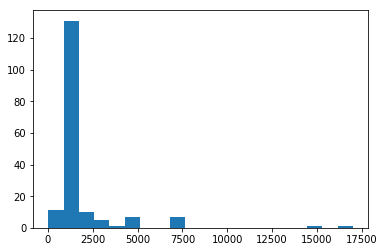

In [123]:
import matplotlib.pyplot as plt

plt.hist(missing_value_counts['number_of_missing_values'], bins=20)
plt.show()

Most columns have less than 2000 missing values.

In [124]:
data_2010.drop(
    columns=missing_value_counts.loc[
        missing_value_counts['number_of_missing_values'] > 2000, 
        'column'].values, 
    inplace=True)

data_2011.drop(
    columns=missing_value_counts.loc[
        missing_value_counts['number_of_missing_values'] > 2000, 
        'column'].values, 
    inplace=True)

In [125]:
print('data_2010:', data_2010.shape)
print('data_2011:', data_2011.shape)

data_2010: (18175, 151)
data_2011: (18315, 151)


### How are variables distributed?

In [126]:
from scipy.stats import normaltest, skewtest, kurtosistest

numerical_distributions = {
    'column': [],
    'normal_test_stat': [],
    'normal_test_pvalue': [],
    'skew_test_stat': [],
    'skew_test_pvalue': [],
    'kurtosis_test_stat': [],
    'kurtosis_test_pvalue': [],
}

for column in numerical_feature_columns:
    if column in data_2010.columns:
        numerical_distributions['column'].append(column)
        normal_test_stat, normal_test_pvalue = normaltest(data_2010[column].values, nan_policy='omit')
        skew_test_stat, skew_test_pvalue = skewtest(data_2010[column].values, nan_policy='omit')
        kurtosis_test_stat, kurtosis_test_pvalue = kurtosistest(data_2010[column].values, nan_policy='omit')
        numerical_distributions['normal_test_stat'].append(normal_test_stat)
        numerical_distributions['normal_test_pvalue'].append(normal_test_pvalue)
        numerical_distributions['skew_test_stat'].append(skew_test_stat)
        numerical_distributions['skew_test_pvalue'].append(skew_test_pvalue)
        numerical_distributions['kurtosis_test_stat'].append(kurtosis_test_stat)
        numerical_distributions['kurtosis_test_pvalue'].append(kurtosis_test_pvalue)
    
numerical_distributions = pd.DataFrame(numerical_distributions)
numerical_distributions

,column,normal_test_stat,normal_test_pvalue,skew_test_stat,skew_test_pvalue,kurtosis_test_stat,kurtosis_test_pvalue
0,total_students,47704.256483,0.0,195.876203,0.0,96.626960,0.0
1,total_revenue,57842.049106,0.0,219.203967,0.0,98.952868,0.0
2,total_federal_revenue,50144.431156,0.0,201.798977,0.0,97.064947,0.0
3,federal_revenue_state_title_i,54694.280508,0.0,212.319033,0.0,98.055641,0.0
4,federal_revenue_ideas,42221.488007,0.0,182.436086,0.0,94.543972,0.0
5,federal_revenue_math_science_quality,51444.214337,0.0,204.757256,0.0,97.563724,0.0
6,federal_revenue_drug_free,52010.719493,0.0,206.185423,0.0,97.459175,0.0
7,federal_revenue_vocational_tech_training,43442.513964,0.0,185.390827,0.0,95.251011,0.0
8,federal_revenue_thru_state_bilingual_education,59436.157649,0.0,222.704002,0.0,99.192162,0.0
9,federal_revenue_thru_state_other,40496.127682,0.0,177.939304,0.0,93.987935,0.0


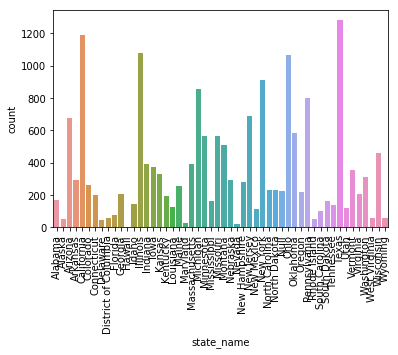

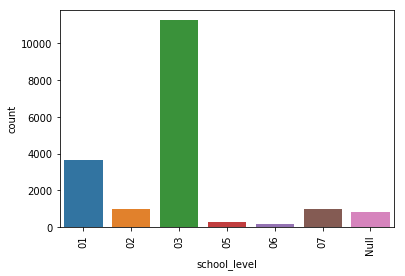

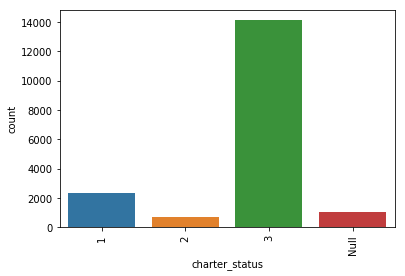

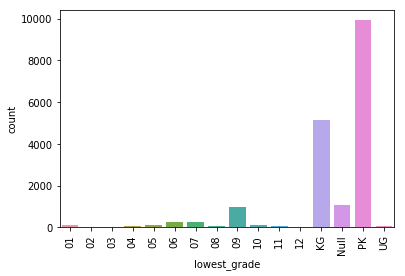

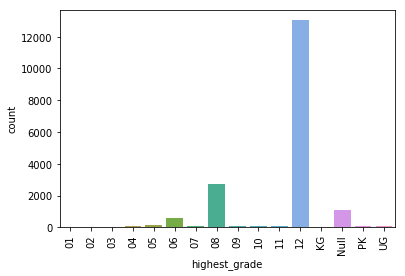

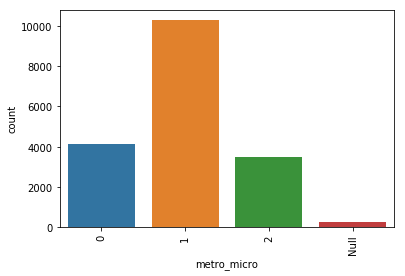

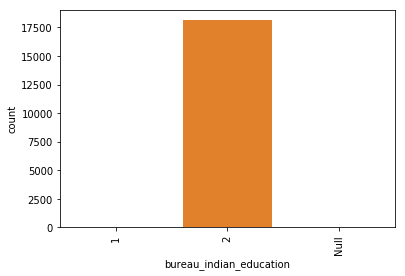

In [127]:
import seaborn as sns

for column in categorical_feature_columns:
    if column in data_2010.columns:
        sns.countplot(x=column, data=data_2010)
        plt.xticks(rotation=90)
        plt.show()

In [128]:
identifier_columns + categorical_feature_columns + numerical_feature_columns

['LEAID',
 'school_district_name',
 'state_name',
 'school_level',
 'charter_status',
 'lowest_grade',
 'highest_grade',
 'metro_micro',
 'bureau_indian_education',
 'total_students',
 'total_revenue',
 'total_federal_revenue',
 'federal_revenue_state_title_i',
 'federal_revenue_ideas',
 'federal_revenue_math_science_quality',
 'federal_revenue_drug_free',
 'federal_revenue_vocational_tech_training',
 'federal_revenue_thru_state_bilingual_education',
 'federal_revenue_thru_state_other',
 'federal_revenue_thru_state_child_nutrition_program',
 'federal_revenue_nonspecified',
 'federal_revenue_impact_aid',
 'federal_revenue_indian_education',
 'federal_revenue_other',
 'total_state_revenue',
 'state_revenue_general_formula_assistance',
 'state_revenue_staff_improvement',
 'state_revenue_special_education',
 'state_revenue_compensatory_basic_training',
 'state_revenue_bilingual_education',
 'state_revenue_gifted_talented',
 'state_revenue_vocational_programs',
 'state_revenue_school_lunch'

In [129]:
data_2010[categorical_feature_columns]

,state_name,school_level,charter_status,lowest_grade,highest_grade,metro_micro,bureau_indian_education
0,Alabama,Null,3,03,12,1,2
1,Alabama,03,3,PK,12,2,2
2,Alabama,03,3,PK,12,2,2
3,Alabama,03,3,PK,12,1,2
4,Alabama,03,3,PK,12,1,2
5,Alabama,Null,3,KG,12,2,2
6,Alabama,03,3,KG,12,1,2
7,Alabama,03,3,PK,12,2,2
8,Alabama,03,3,KG,12,1,2
9,Alabama,Null,3,06,12,1,2


# Feature Engineering

### Demographics by proportion of total population

In [130]:
demographic_columns = [
    'american_indian_alaskan_native_students',
    'american_indian_alaskan_native_male_students',
    'american_indian_alaskan_native_female_students',
    'asian_hawaiian_native_pacific_islander_students',
    'asian_hawaiian_native_pacific_islander_male_students',
    'asian_hawaiian_native_pacific_islander_female_students',
    'hispanic_students',
    'hispanic_male_students',
    'hispanic_female_students',
    'black_non_hispanic_students',
    'black_non_hispanic_male_students',
    'black_non_hispanic_female_students',
    'white_students',
    'white_male_students',
    'white_female_students',
    'hawaiian_native_pacific_islander_students',
    'hawaiian_native_pacific_islander_male_students',
    'hawaiian_native_pacific_islander_female_students',
    'mixed_race_students',
    'mixed_race_male_students',
    'mixed_race_female_students'
]

for column in demographic_columns:
    if column in data_2010.columns:
        data_2010[column+'_proportion'] = data_2010[column] / data_2010['total_students']
        data_2011[column+'_proportion'] = data_2011[column] / data_2011['total_students']

### Revenue as a proportion of total revenue

In [131]:
revenue_columns = [
    'local_revenue',
    'state_revenue',
    'federal_revenue'
]

for column in revenue_columns:
    if column in data_2010.columns:
        data_2010[column+'_proportion'] = data_2010[column] / data_2010['total_revenue']
        data_2011[column+'_proportion'] = data_2011[column] / data_2011['total_revenue']

### NA_Values

In [132]:
from fancyimpute import KNN
imp = IterativeImputer()
for column in data_2010.columns:
    data_2010[column+'_NA'] = pd.isnull(data_2010[column])
    data_2011[column+'_NA'] = pd.isnull(data_2011[column])

impute_columns = [column for column in data_2010 if pd.isnull(data_2010[column]).sum() > 0]
data_2010[impute_columns] = KNN(k=5, verbose=False).fit_transform(data_2010[impute_columns])
data_2011[impute_columns] = KNN(k=3, verbose=False).fit_transform(data_2011[impute_columns])

In [133]:
print(data_2010.shape)
print(data_2011.shape)
print(pd.isnull(data_2010).sum().sum())
print(pd.isnull(data_2011).sum().sum())

(18175, 330)
(18315, 330)
0
0


### Adjust Target

# Build a Model

### Split Sets

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data_2010.drop(columns=['exist_five_years', 'closed_five_years']), 
    data_2010[label_columns], 
    test_size=0.2, 
    random_state=93
)
X_train = pd.get_dummies(X_train, columns=categorical_feature_columns)
X_train = X_train.fillna(0)
X_val = pd.get_dummies(X_val, columns=categorical_feature_columns)
X_val = X_val.fillna(0)

X_test = data_2011.drop(columns=['exist_five_years', 'closed_five_years']).copy()
X_test = pd.get_dummies(X_test, columns=categorical_feature_columns)
X_test = X_test.fillna(0)
y_test = data_2011[label_columns].copy()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(14540, 423)
(3635, 423)
(18315, 423)
(14540, 2)
(3635, 2)
(18315, 2)


Logloss: 0.3582778991, Precision: 0.1731543624, Recall: 0.8113207547


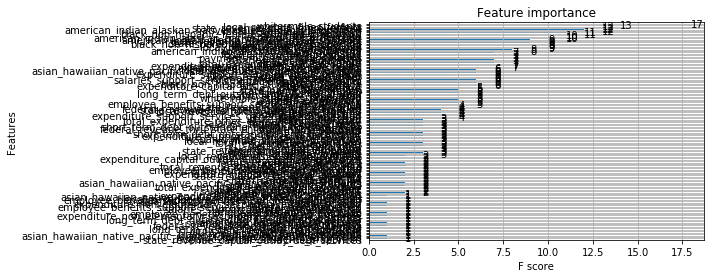

In [147]:
from xgboost import XGBClassifier, plot_importance
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import log_loss, precision_score, recall_score

xgb_clf = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train['closed_five_years']))/sum(y_train['closed_five_years'])
)

xgb_clf.fit(X_train.drop(columns=['LEAID', 'school_district_name']), y_train['closed_five_years'])
xgb_probabilities = xgb_clf.predict_proba(X_val.drop(columns=['LEAID', 'school_district_name']))
xgb_predictions = xgb_clf.predict(X_val.drop(columns=['LEAID', 'school_district_name']))

logloss_score = log_loss(y_val['closed_five_years'], xgb_probabilities)

print(
    "Logloss: %.10f, Precision: %.10f, Recall: %.10f" % (
        logloss_score,
        precision_score(y_val['closed_five_years'], xgb_predictions),
        recall_score(y_val['closed_five_years'], xgb_predictions)
    )
)

feature_importances = {
    'feature': X_train.drop(columns=['LEAID', 'school_district_name']).columns,
    'score': xgb_clf.feature_importances_
}
feature_importances = pd.DataFrame(feature_importances)

plot_importance(xgb_clf)
plt.show()

In [146]:
feature_importances.sort_values('score')

,feature,score
210,total_expenditure_instruction_NA,0.000000
263,employee_benefits_support_services_business_NA,0.000000
262,employee_benefits_support_transportation_NA,0.000000
261,employee_benefits_support_services_maintenance_NA,0.000000
260,employee_benefits_support_services_school_admi...,0.000000
259,employee_benefits_support_services_general_adm...,0.000000
258,employee_benefits_support_services_instruction...,0.000000
257,employee_benefits_support_services_pupil_NA,0.000000
256,employee_benefits_instruction_NA,0.000000
255,total_employee_benefits_NA,0.000000


In [148]:
from xgboost import XGBClassifier, plot_importance
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel

xgb_clf = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train['closed_five_years']))/sum(y_train['closed_five_years'])
)

xgb_clf.fit(X_train.drop(columns=['LEAID', 'school_district_name']), y_train['closed_five_years'])

for thresh in np.unique(np.sort(feature_importances['score'].values)):
    # train model
    selection_model = XGBClassifier(
        scale_pos_weight=(len(y_train)-sum(y_train['closed_five_years']))/sum(y_train['closed_five_years'])
    )
    selection_model.fit(
        X_train[feature_importances.loc[feature_importances['score'] >= thresh, 'feature']],
        y_train['closed_five_years']
    )
    # eval model
    y_pred_proba = selection_model.predict_proba(
        X_val[feature_importances.loc[feature_importances['score'] >= thresh, 'feature']]
    )
    y_pred = selection_model.predict(
        X_val[feature_importances.loc[feature_importances['score'] >= thresh, 'feature']]
    )
    logloss_score = log_loss(y_val['closed_five_years'], y_pred_proba)
    print(
        "Thresh=%.6f, n=%d, Logloss: %.10f, Precision: %.10f, Recall: %.10f" % (
            thresh,
            X_train[feature_importances.loc[feature_importances['score'] >= thresh, 'feature']].shape[1],
            logloss_score,
            precision_score(y_val['closed_five_years'], y_pred),
            recall_score(y_val['closed_five_years'], y_pred)
        )
    )

Thresh=0.000000, n=421, Logloss: 0.3582778991, Precision: 0.1731543624, Recall: 0.8113207547
Thresh=0.001590, n=151, Logloss: 0.3582778991, Precision: 0.1731543624, Recall: 0.8113207547
Thresh=0.003180, n=119, Logloss: 0.3576525659, Precision: 0.1689008043, Recall: 0.7924528302
Thresh=0.004769, n=92, Logloss: 0.3610595495, Precision: 0.1727891156, Recall: 0.7987421384
Thresh=0.006359, n=66, Logloss: 0.3651938934, Precision: 0.1651612903, Recall: 0.8050314465
Thresh=0.007949, n=57, Logloss: 0.3656410025, Precision: 0.1642949547, Recall: 0.7987421384
Thresh=0.009539, n=44, Logloss: 0.3730776343, Precision: 0.1600496278, Recall: 0.8113207547
Thresh=0.011129, n=31, Logloss: 0.3914862928, Precision: 0.1457399103, Recall: 0.8176100629
Thresh=0.012719, n=20, Logloss: 0.4088795986, Precision: 0.1341589267, Recall: 0.8176100629
Thresh=0.014308, n=18, Logloss: 0.4110500819, Precision: 0.1341463415, Recall: 0.8301886792
Thresh=0.015898, n=11, Logloss: 0.4362898941, Precision: 0.1356107660, Recall

In [ ]:
keep_features = feature_importances.loc[feature_importances['score'] >= 0.013, 'feature'].values

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train[keep_features], y_train['exist_five_years'])
xgb_predictions = xgb_clf.predict(X_val[keep_features])

logloss_score = log_loss(y_val['exist_five_years'], xgb_predictions)
print('logloss:', logloss_score)

plot_importance(xgb_clf)
plt.show()

In [ ]:
len(keep_features)

In [165]:
import eli5
from eli5.sklearn import PermutationImportance

xgb_clf = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train['closed_five_years']))/sum(y_train['closed_five_years'])
)
xgb_clf.fit(
    X_train[feature_importances.loc[feature_importances['score'] >= 0.014308, 'feature']],
    y_train['closed_five_years']
)

perm = PermutationImportance(xgb_clf, random_state=1).fit(
    X_val[feature_importances.loc[feature_importances['score'] >= 0.014308, 'feature']].astype('float64'), 
    y_val['closed_five_years'].astype('float64')
)
# eli5.show_weights(
#     perm,
#     feature_names = X_val[feature_importances.loc[feature_importances['score'] >= 0.014308, 'feature']].columns.tolist())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [162]:
feature_importances.loc[feature_importances['score'] >= 0.014308, 'feature']

1                                          total_revenue
17                       state_revenue_staff_improvement
29                   state_revenue_not_employee_benefits
35                            local_revenue_school_lunch
37               local_revenue_district_activity_receipt
42                       local_revenue_interest_earnings
43                          local_revenue_fines_forfeits
64                                expenditure_enterprise
113                            ARRA_current_expenditures
127         american_indian_alaskan_native_male_students
138                                  white_male_students
140    american_indian_alaskan_native_students_propor...
141    american_indian_alaskan_native_male_students_p...
149          black_non_hispanic_male_students_proportion
150        black_non_hispanic_female_students_proportion
286                           administrators_district_NA
358                              state_name_Pennsylvania
365                            

In [166]:
X_val[feature_importances.loc[feature_importances['score'] >= 0.014308, 'feature']]

,total_revenue,state_revenue_staff_improvement,state_revenue_not_employee_benefits,local_revenue_school_lunch,local_revenue_district_activity_receipt,local_revenue_interest_earnings,local_revenue_fines_forfeits,expenditure_enterprise,ARRA_current_expenditures,american_indian_alaskan_native_male_students,white_male_students,american_indian_alaskan_native_students_proportion,american_indian_alaskan_native_male_students_proportion,black_non_hispanic_male_students_proportion,black_non_hispanic_female_students_proportion,administrators_district_NA,state_name_Pennsylvania,state_name_Vermont
4956,1.738000e+06,7.400000e+04,0.0,13000.0,0.0,2.000000e+03,0.0,0.0,106000.0,0.000000,30.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,False,0,0
17720,1.814100e+07,0.000000e+00,0.0,217000.0,53000.0,2.000000e+03,1000.0,0.0,227000.0,17.000000,631.000000,3.368263e-02,1.272455e-02,5.239521e-03,0.013473,False,0,0
5711,7.879500e+07,1.000000e+03,0.0,1017000.0,9000.0,2.640000e+05,0.0,0.0,4451000.0,3.000000,3948.000000,7.423905e-04,3.711952e-04,4.949270e-03,0.004207,False,0,0
6905,2.111800e+07,0.000000e+00,0.0,163000.0,183000.0,1.800000e+04,0.0,0.0,743000.0,18.000000,967.000000,1.694095e-02,8.712488e-03,6.292352e-03,0.003872,False,0,0
14158,5.201100e+07,1.760000e+06,0.0,813000.0,18000.0,1.750000e+05,0.0,0.0,2701000.0,2.000000,2028.000000,9.722897e-04,4.861449e-04,1.944579e-03,0.001458,False,1,0
2255,7.408000e+07,1.030000e+05,0.0,530000.0,0.0,1.099000e+06,0.0,0.0,5167000.0,24.000000,1015.000000,5.136051e-03,2.622664e-03,2.677303e-02,0.022948,False,0,0
17765,3.226400e+07,0.000000e+00,0.0,567000.0,92000.0,7.100000e+04,0.0,0.0,734000.0,16.000000,1243.000000,1.104762e-02,6.095238e-03,7.238095e-03,0.009905,False,0,0
15688,2.303800e+07,0.000000e+00,53000.0,316000.0,21000.0,1.800000e+04,0.0,0.0,654000.0,4.000000,353.000000,6.793478e-03,2.717391e-03,1.460598e-01,0.123641,False,0,0
13036,2.930900e+07,0.000000e+00,0.0,0.0,0.0,2.990000e+05,0.0,166000.0,0.0,-8.800000,-8.800000,0.000000e+00,0.000000e+00,2.568615e-01,0.262338,False,0,0
16547,4.895000e+06,0.000000e+00,0.0,44000.0,4000.0,3.000000e+03,0.0,0.0,130000.0,0.000000,141.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.003610,False,0,1
